# Importação das bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Importação do dataset

In [ ]:
tabela = pd.read_csv('/content/drive/MyDrive/Projeto de Pesquisa/Artigo/dataset/predictive_maintenance.csv')
tabela.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [ ]:
tabela.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [ ]:
tabela['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

# Proposta

## Pré-processamento

In [ ]:
tabela['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

In [ ]:
falhas_aleatorias = tabela[tabela['Failure Type'] == 'Random Failures'].index
falha_de_desgaste_de_ferramenta = tabela[tabela['Failure Type'] == 'Tool Wear Failure'].index

tabela = tabela.drop(falhas_aleatorias, axis=0)
tabela = tabela.drop(falha_de_desgaste_de_ferramenta, axis=0)

tabela['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Name: Failure Type, dtype: int64

In [ ]:
# Remoção de colunas desnecessárias
colunas = ['UDI', 'Product ID', 'Failure Type']
tabela = tabela.drop(colunas, axis=1)
tabela.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


In [ ]:
# Alterando o tipo da coluna Type de categórico para numérico
type_columns_converting = pd.get_dummies(data=tabela['Type'])

tabela = tabela.assign(H=type_columns_converting['H'],
                             L=type_columns_converting['L'],
                             M=type_columns_converting['M'])

tabela = tabela[['H', 'L', 'M',
                 'Air temperature [K]',
                 'Process temperature [K]',
                 'Rotational speed [rpm]',
                 'Torque [Nm]',
                 'Tool wear [min]',
                 'Target']]

tabela.columns = ['H', 'L', 'M',
                  'Air Temperature',
                  'Process Temperature',
                  'Rotational Speed',
                  'Torque',
                  'Tool Wear',
                  'Target']

tabela.head()

,H,L,M,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Target
0,0,0,1,298.1,308.6,1551,42.8,0,0
1,0,1,0,298.2,308.7,1408,46.3,3,0
2,0,1,0,298.1,308.5,1498,49.4,5,0
3,0,1,0,298.2,308.6,1433,39.5,7,0
4,0,1,0,298.2,308.7,1408,40.0,9,0


In [ ]:
tabela.describe()

,H,L,M,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Target
count,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000
mean,0.099930,0.600081,0.299990,300.002264,310.003482,1538.721043,39.993006,107.437557,0.029586
std,0.299921,0.489906,0.458276,2.000662,1.483394,179.245643,9.967446,63.363141,0.169452
min,0.000000,0.000000,0.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,0.000000,1.000000,0.000000,300.100000,310.100000,1503.000000,40.100000,107.000000,0.000000
75%,0.000000,1.000000,1.000000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,1.000000,1.000000,1.000000,304.500000,313.800000,2886.000000,76.600000,251.000000,1.000000


In [ ]:
x = tabela.drop('Target', axis=1)
y = tabela['Target']

In [ ]:
escalador = MinMaxScaler()
x = escalador.fit_transform(x)
x = pd.DataFrame(data=x, columns=['H', 'L', 'M',
                  'Air Temperature',
                  'Process Temperature',
                  'Rotational Speed',
                  'Torque',
                  'Tool Wear',])
x.describe()

,H,L,M,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear
count,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000
mean,0.099930,0.600081,0.299990,0.511116,0.531294,0.215786,0.497157,0.428038
std,0.299921,0.489906,0.458276,0.217463,0.183135,0.104334,0.136915,0.252443
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.326087,0.382716,0.148428,0.403846,0.211155
50%,0.000000,1.000000,0.000000,0.521739,0.543210,0.194994,0.498626,0.426295
75%,0.000000,1.000000,1.000000,0.673913,0.666667,0.258440,0.590659,0.645418
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


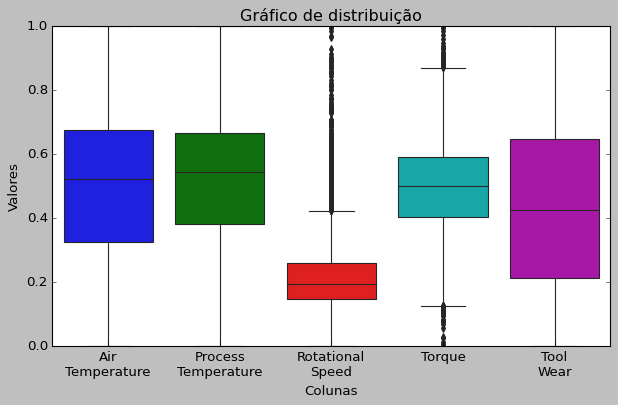

In [ ]:
x_boxplot = x[['Air Temperature', 'Process Temperature', 'Rotational Speed', 'Torque', 'Tool Wear']]
x_boxplot.columns = ['Air\nTemperature', 'Process\nTemperature', 'Rotational\nSpeed', 'Torque', 'Tool\nWear']
boxplot = sns.boxplot(data=x_boxplot[['Air\nTemperature', 'Process\nTemperature', 'Rotational\nSpeed', 'Torque', 'Tool\nWear']]);
boxplot.figure.set_size_inches(9, 5)
plt.title('Gráfico de distribuição')
plt.xlabel('Colunas')
plt.ylabel('Valores')
plt.savefig('Boxplot.png')

## Separação dos subconjuntos de treino, teste e validação

In [ ]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=42, stratify=y, train_size=0.80)
x_teste, x_validacao, y_teste, y_validacao = train_test_split(x_teste, y_teste, random_state=42, stratify=y_teste, train_size=0.5)

In [ ]:
print('Tamanho dos conjuntos')
print('Conjunto\tQtd. Linhas\tQtd. Colunas')
print(f'X Treino\t{x_treino.shape[0]}\t\t{x_treino.shape[1]}')
print(f'Y Treino\t{y_treino.shape[0]}\t\t1')
print(f'X Teste\t\t{x_teste.shape[0]}\t\t{x_teste.shape[1]}')
print(f'Y Teste\t\t{y_teste.shape[0]}\t\t1')
print(f'X Validação\t{x_validacao.shape[0]}\t\t{x_validacao.shape[1]}')
print(f'Y Validação\t{y_validacao.shape[0]}\t\t1')

Tamanho dos conjuntos
Conjunto	Qtd. Linhas	Qtd. Colunas
X Treino	7949		8
Y Treino	7949		1
X Teste		994		8
Y Teste		994		1
X Validação	994		8
Y Validação	994		1


## Aplicação dos modelos

### Árvore de Decisão

In [ ]:
parametros_arvore_decisao = {
   'max_depth': np.arange(1, 20) 
}

grid_search_arvore_decisao = GridSearchCV(DecisionTreeClassifier(), parametros_arvore_decisao, cv=5, scoring='recall')
grid_search_arvore_decisao.fit(x_treino, y_treino)
melhores_parametros_arvore_decisao = grid_search_arvore_decisao.best_params_
melhores_parametros_arvore_decisao

{'max_depth': 19}

In [ ]:
clf_tree = DecisionTreeClassifier(max_depth=melhores_parametros_arvore_decisao['max_depth'])
validacao_cruzada_arvore_decisao = cross_validate(estimator=clf_tree, X=x_validacao, y=y_validacao, cv=5, return_train_score=True)
validacao_cruzada_arvore_decisao

{'fit_time': array([0.01040816, 0.00570774, 0.00613451, 0.0106504 , 0.02472401]),
 'score_time': array([0.00398636, 0.0070405 , 0.00954008, 0.01235747, 0.00716996]),
 'test_score': array([0.9798995 , 0.9798995 , 0.98492462, 0.9798995 , 0.97979798]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [ ]:
clf_tree.fit(x_treino, y_treino)
predicao = clf_tree.predict(x_teste)

In [ ]:
resultados = classification_report(y_teste, predicao) 
print(resultados)

acuracia_arvore_decisao = clf_tree.score(x_teste, y_teste) * 100
precisao_arvore_decisao = precision_score(y_teste, predicao, average="weighted") * 100
revocacao_arvore_decisao = recall_score(y_teste, predicao, average="weighted") * 100
f1_arvore_decisao = f1_score(y_teste, predicao, average="weighted") * 100
print(f'Acurácia: {acuracia_arvore_decisao:.2f}')
print(f'Precisão Média: {precisao_arvore_decisao:.2f}')
print(f'Revocação Média: {revocacao_arvore_decisao:.2f}')
print(f'F1 Média: {f1_arvore_decisao:.2f}')

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       964
           1       0.76      0.93      0.84        30

    accuracy                           0.99       994
   macro avg       0.88      0.96      0.92       994
weighted avg       0.99      0.99      0.99       994

Acurácia: 98.89
Precisão Média: 99.06
Revocação Média: 98.89
F1 Média: 98.95


### Teorema de Bayes

In [ ]:
clf_bayes = GaussianNB()

In [ ]:
validacao_cruzada_naive_bayes = cross_validate(estimator=clf_tree, X=x_validacao, y=y_validacao, return_train_score=True)
validacao_cruzada_naive_bayes

{'fit_time': array([0.01307845, 0.01741099, 0.01344156, 0.01305151, 0.00550652]),
 'score_time': array([0.00867271, 0.00401092, 0.00308967, 0.00315356, 0.00304937]),
 'test_score': array([0.9798995 , 0.9798995 , 0.98492462, 0.9798995 , 0.98484848]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [ ]:
clf_bayes.fit(x_treino, y_treino)
predicao_naive_bayes = clf_bayes.predict(x_teste)

In [ ]:
print(classification_report(y_teste, predicao_naive_bayes))

acuracia_naive_bayes = clf_bayes.score(x_teste, y_teste) * 100
precisao_naive_bayes = precision_score(y_teste, predicao_naive_bayes, average="weighted") * 100
revocacao_naive_bayes = recall_score(y_teste, predicao_naive_bayes, average="weighted") * 100
f1_naive_bayes = f1_score(y_teste, predicao_naive_bayes, average="weighted") * 100
print(f'Acurácia: {acuracia_naive_bayes:.2f}')
print(f'Precisão Média: {precisao_naive_bayes:.2f}')
print(f'Revocação Média: {revocacao_naive_bayes:.2f}')
print(f'F1 Média: {f1_naive_bayes:.2f}')

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       964
           1       0.22      0.13      0.17        30

    accuracy                           0.96       994
   macro avg       0.60      0.56      0.57       994
weighted avg       0.95      0.96      0.95       994

Acurácia: 95.98
Precisão Média: 95.07
Revocação Média: 95.98
F1 Média: 95.49


### SVM

In [ ]:
clf_svm = SVC(C=100, kernel='rbf', gamma='scale')
validacao_cruzada_svm = cross_validate(estimator=clf_svm, X=x_validacao, y=y_validacao, return_train_score=True)
validacao_cruzada_svm

{'fit_time': array([0.03578377, 0.01752973, 0.02848816, 0.01403308, 0.01414704]),
 'score_time': array([0.00509405, 0.00430512, 0.01160932, 0.00448012, 0.00449347]),
 'test_score': array([0.98492462, 0.95979899, 0.97487437, 0.97487437, 0.96969697]),
 'train_score': array([0.98490566, 0.98993711, 0.98993711, 0.98993711, 0.99246231])}

In [ ]:
clf_svm.fit(x_treino, y_treino)
predicao_svm = clf_svm.predict(x_teste)

In [ ]:
print(classification_report(y_teste, predicao))

acuracia_svm = clf_svm.score(x_teste, y_teste) * 100
precisao_svm = precision_score(y_teste, predicao_svm, average="weighted") * 100
revocacao_svm = recall_score(y_teste, predicao_svm, average="weighted") * 100
f1_svm = f1_score(y_teste, predicao, average="weighted") * 100
print(f'Acurácia: {acuracia_svm:.2f}')
print(f'Precisão Média: {precisao_svm:.2f}')
print(f'Revocação Média: {revocacao_svm:.2f}')
print(f'F1 Média: {f1_svm:.2f}')

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       964
           1       0.76      0.93      0.84        30

    accuracy                           0.99       994
   macro avg       0.88      0.96      0.92       994
weighted avg       0.99      0.99      0.99       994

Acurácia: 98.39
Precisão Média: 98.25
Revocação Média: 98.39
F1 Média: 98.95


### XGBoost

In [ ]:
parametros_xgb = {
    'booster': ['dart', 'gbtree'],
    'tree_method': ['auto', 'approx', 'hist', 'exact'],
    'eta': np.arange(0.1, 0.205, 0.05),
    'gamma': np.arange(0, 101),
    'max_depth': np.arange(3, 12),
    'objective': ['binary:hinge'],
    'eval_metric': ['error', 'auc', 'aucpr']
}

randomized_search_xgb = RandomizedSearchCV(estimator=XGBClassifier(),
                                           param_distributions=parametros_xgb,
                                           n_iter=10,
                                           scoring='accuracy',
                                           cv=5,
                                           return_train_score=True)

randomized_search_xgb.fit(x_treino, y_treino)
melhores_parametros_xgb = randomized_search_xgb.best_params_
melhores_parametros_xgb

{'booster': 'dart',
 'eta': 0.15000000000000002,
 'eval_metric': 'error',
 'gamma': 0,
 'max_depth': 7,
 'objective': 'binary:hinge',
 'tree_method': 'exact'}

In [ ]:
randomized_search_xgb.cv_results_['mean_test_score']

array([0.98679063, 0.98641335, 0.97182057, 0.97182073, 0.971569  ,
       0.97886555, 0.96993323, 0.98918049, 0.971569  , 0.97043693])

In [ ]:
randomized_search_xgb.cv_results_['mean_train_score']

array([0.99430744, 0.99996855, 0.97288962, 0.97266948, 0.9725122 ,
       0.98131841, 0.96993335, 1.        , 0.9725122 , 0.97213478])

In [ ]:
clf_xgb = XGBClassifier(booster=melhores_parametros_xgb['booster'],
                        max_depth=melhores_parametros_xgb['max_depth'],
                        objective=melhores_parametros_xgb['objective'],
                        eval_metric=melhores_parametros_xgb['eval_metric'])
validacao_cruzada = cross_validate(estimator=clf_xgb, X=x_treino, y=y_treino, cv=5, return_train_score=True)
validacao_cruzada

{'fit_time': array([1.7494607 , 1.92586422, 1.88146591, 1.54832101, 1.81839848]),
 'score_time': array([0.00789666, 0.00919271, 0.00900888, 0.00700545, 0.00878525]),
 'test_score': array([0.99056604, 0.99119497, 0.9918239 , 0.98742138, 0.98489616]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [ ]:
clf_xgb.fit(x_treino, y_treino)

XGBClassifier(booster='dart', eval_metric='error', max_depth=7,
              objective='binary:hinge')

In [ ]:
predicao_xgb = clf_xgb.predict(x_teste)
print(classification_report(y_teste, predicao))

acuracia_xgb = clf_xgb.score(x_teste, y_teste) * 100
precisao_xgb = precision_score(y_teste, predicao_xgb, average='weighted') * 100
revocacao_xgb = recall_score(y_teste, predicao_xgb, average='weighted') * 100
f1_xgb = f1_score(y_teste, predicao_xgb, average='weighted') * 100
print(f'Acurácia: {acuracia_xgb:.2f}')
print(f'Precisão Média: {precisao_xgb:.2f}')
print(f'Revocação Média: {revocacao_xgb:.2f}')
print(f'F1 Média: {f1_xgb:.2f}')

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       964
           1       0.76      0.93      0.84        30

    accuracy                           0.99       994
   macro avg       0.88      0.96      0.92       994
weighted avg       0.99      0.99      0.99       994

Acurácia: 98.79
Precisão Média: 98.79
Revocação Média: 98.79
F1 Média: 98.79


# Resultados

## Acurácia

In [ ]:
round(acuracia_svm, 2), round(acuracia_arvore_decisao, 2), round(acuracia_naive_bayes, 2), round(acuracia_xgb, 2)

(98.39, 98.89, 95.98, 98.79)

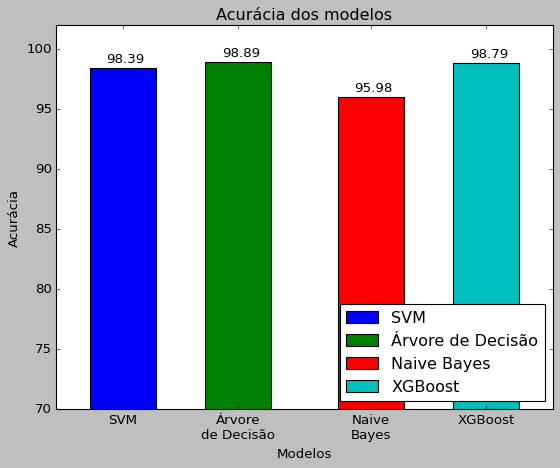

In [ ]:
plt.style.use('classic')
modelos = ['SVM', 'Árvore\nde Decisão', 'Naive\nBayes', 'XGBoost']

figure_acuracia, ax_acuracia = plt.subplots()
plt.title('Acurácia dos modelos')
ax_acuracia.bar(2 - 0.2, acuracia_svm, label='SVM')
plt.text(1.6, acuracia_svm + 0.5, round(acuracia_svm, 2))
ax_acuracia.bar(3 + 0.2, acuracia_arvore_decisao, label='Árvore de Decisão')
plt.text(3, acuracia_arvore_decisao + 0.5, round(acuracia_arvore_decisao, 2))
ax_acuracia.bar(5 - 0.2, acuracia_naive_bayes, label='Naive Bayes')
plt.text(4.6, acuracia_naive_bayes + 0.5, round(acuracia_naive_bayes, 2))
ax_acuracia.bar(6 + 0.2, acuracia_xgb, label='XGBoost')
plt.text(6, acuracia_xgb + 0.5, round(acuracia_xgb, 2))
plt.xticks([1.8, 3.2, 4.8, 6.2], modelos)
plt.xlabel('Modelos')
ax_acuracia.set_ylabel('Acurácia')
ax_acuracia.set_ylim([70, 102])
plt.legend(loc='lower right')

plt.savefig('Resultados - Acurácia.png')

plt.show();

## Precisão

In [ ]:
round(precisao_svm, 2), round(precisao_arvore_decisao, 2), round(precisao_naive_bayes, 2), round(precisao_xgb, 2)

(98.25, 99.06, 95.07, 98.79)

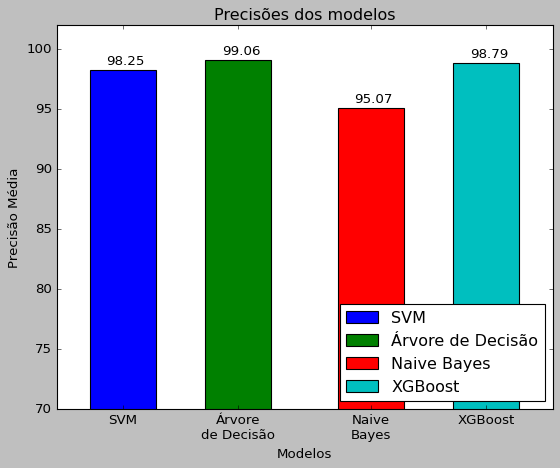

In [ ]:
figure_acuracia, ax_precisao = plt.subplots()
plt.title('Precisões dos modelos')
ax_precisao.bar(2 - 0.2, precisao_svm, label='SVM')
plt.text(1.6, precisao_svm + 0.5, round(precisao_svm, 2))
ax_precisao.bar(3 + 0.2, precisao_arvore_decisao, label='Árvore de Decisão')
plt.text(3, precisao_arvore_decisao + 0.5, round(precisao_arvore_decisao, 2))
ax_precisao.bar(5 - 0.2, precisao_naive_bayes, label='Naive Bayes')
plt.text(4.6, precisao_naive_bayes + 0.5, round(precisao_naive_bayes, 2))
ax_precisao.bar(6 + 0.2, precisao_xgb, label='XGBoost')
plt.text(6, precisao_xgb + 0.5, round(precisao_xgb, 2))
plt.xticks([1.8, 3.2, 4.8, 6.2], modelos)
ax_precisao.set_xlabel('Modelos')
ax_precisao.set_ylabel('Precisão Média')
ax_precisao.set_ylim([70, 102])
plt.legend(loc='lower right')

plt.savefig('Resultados - Precisão.png')

plt.show()

## Revocação

In [ ]:
round(revocacao_svm, 2), round(revocacao_arvore_decisao, 2), round(revocacao_naive_bayes, 2), round(revocacao_xgb, 2)

(98.39, 98.89, 95.98, 98.79)

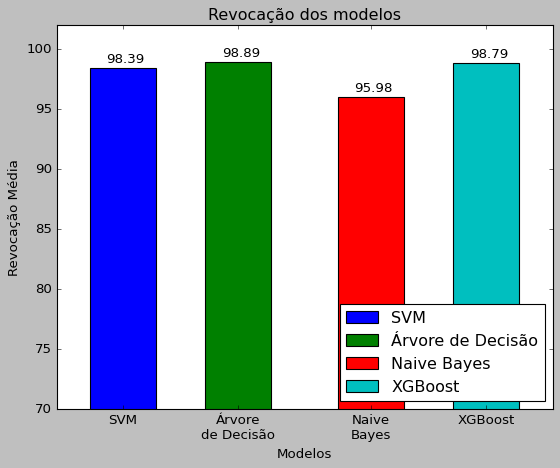

In [ ]:
figure_acuracia, ax_revocacao = plt.subplots()
plt.title('Revocação dos modelos')
ax_revocacao.bar(2 - 0.2, revocacao_svm, label='SVM')
plt.text(1.6, revocacao_svm + 0.5, round(revocacao_svm, 2))
ax_revocacao.bar(3 + 0.2, revocacao_arvore_decisao, label='Árvore de Decisão')
plt.text(3, revocacao_arvore_decisao + 0.5, round(revocacao_arvore_decisao, 2))
ax_revocacao.bar(5 - 0.2, revocacao_naive_bayes, label='Naive Bayes')
plt.text(4.6, revocacao_naive_bayes + 0.5, round(revocacao_naive_bayes, 2))
ax_revocacao.bar(6 + 0.2, revocacao_xgb, label='XGBoost')
plt.text(6, revocacao_xgb + 0.5, round(revocacao_xgb, 2))
plt.xticks([1.8, 3.2, 4.8, 6.2], modelos)
ax_revocacao.set_xlabel('Modelos')
ax_revocacao.set_ylabel('Revocação Média')
ax_revocacao.set_ylim([70, 102])
plt.legend(loc='lower right')

plt.savefig('Resultados - Revocação.png')

plt.show()

## Tempo de Treinamento

In [ ]:
round(validacao_cruzada_arvore_decisao['fit_time'].mean(), 3), round(validacao_cruzada_naive_bayes['fit_time'].mean(), 3), round(validacao_cruzada_svm['fit_time'].mean(), 3), round(validacao_cruzada['fit_time'].mean(), 3)

(0.012, 0.012, 0.022, 1.785)

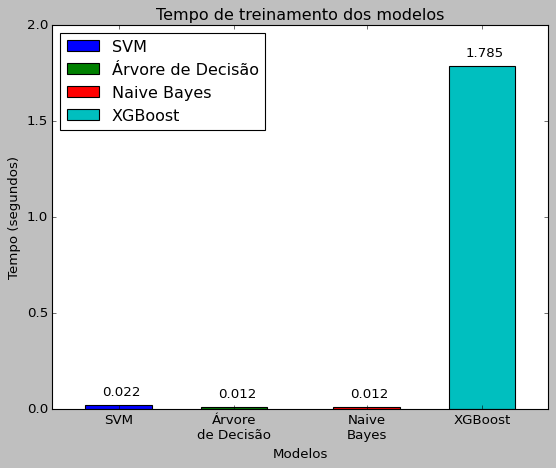

In [ ]:
figure_acuracia, ax_tempo = plt.subplots()
plt.title('Tempo de treinamento dos modelos')
ax_tempo.bar(2 - 0.2, validacao_cruzada_svm['fit_time'].mean(), label='SVM')
plt.text(1.6, validacao_cruzada_svm['fit_time'].mean() + 0.05, round(validacao_cruzada_svm['fit_time'].mean(), 4))
ax_tempo.bar(3 + 0.2, validacao_cruzada_arvore_decisao['fit_time'].mean(), label='Árvore de Decisão')
plt.text(3, validacao_cruzada_arvore_decisao['fit_time'].mean() + 0.05, round(validacao_cruzada_arvore_decisao['fit_time'].mean(), 3))
ax_tempo.bar(5 - 0.2, validacao_cruzada_naive_bayes['fit_time'].mean(), label='Naive Bayes')
plt.text(4.6, validacao_cruzada_naive_bayes['fit_time'].mean() + 0.05, round(validacao_cruzada_naive_bayes['fit_time'].mean(), 3))
ax_tempo.bar(6 + 0.2, validacao_cruzada['fit_time'].mean(), label='XGBoost')
plt.text(6, validacao_cruzada['fit_time'].mean() + 0.05, round(validacao_cruzada['fit_time'].mean(), 3))
plt.xticks([1.8, 3.2, 4.8, 6.2], modelos)
ax_tempo.set_xlabel('Modelos')
ax_tempo.set_ylabel('Tempo (segundos)')
ax_tempo.set_ylim([0, 2])
plt.legend(loc='upper left')

plt.savefig('Resultados - Tempo de Treinamento.png')

plt.show()